# Example XRISM/Resolve simulation
---

Developed using anaconda distribution of Python 3.11 including astropy. \
Use Heasoft and SPEX.


## Create a SPEX source model in qdp format

In [1]:
import os,sys
from subprocess import check_call, Popen, PIPE
from astropy import log
import numpy as np
import math
from astropy.io import fits
#from xspec import *
import matplotlib.pyplot as plt
os.environ['HEADASNOQUERY']='1'
print(os.getenv('CONDA_PREFIX'))
from pyspex.spex import Session
s=Session()

/home/idies/miniconda3/envs/spex
 Welcome idies to SPEX version 3.07.03

 NEW in this version of SPEX: 
01-12-2022 Fixed issue with plot cap command
05-12-2022 Fixed issue with knak model
22-03-2023 Fixed issue with treatment of bad quality bins in trafo
23-03-2023 Fixed small issues in the pyspex interface

 Currently using SPEXACT version 2.07.00. Type `help var calc` for details.


In [2]:
# Set up the model
s.com('reds')
s.com('hot')
s.com('cie')
# relate components
s.com_rel(1,3,np.array([1,2]))
s.par(1,1,'z',0.01)
s.par(1,2,'nh',1E-3)
# set distance
s.dist(1,0.01,'z')
## important!
## to convert unit from SPEX (photon s-1 m-2 kev-1) to HEASIM (photon s-1 cm-2 kev-1)
## divide normalization by a factor of 1e4
## norm = 1e8 (original) -> 1e4 
s.par(1,3,'norm',1E+4,thawn=True)
s.par(1,3,'t',2.0,thawn=True)

 You have defined    1 component.
 You have defined    2 components.
 You have defined    3 components.
 Distances assuming H0 =  70.0 km/s/Mpc, Omega_m = 0.300 Omega_Lambda = 0.700 Omega_r = 0.000
Sector       m      A.U.        ly        pc       kpc       Mpc  redshift        cz   age(yr)
----------------------------------------------------------------------------------------------
   1 1.332E+24 8.902E+12 1.408E+08 4.316E+07 4.316E+04   43.1582    0.0100    2997.9 1.387E+08
----------------------------------------------------------------------------------------------



In [3]:
# setup energy grid 
s.egrid(0.1,27.1,27000,'kev',False)
# use old atomic data for now 
s.var_calc(False)
s.calc()

 Your energy grid contains 27000 bins.
 Start energy:    0.10000     keV
 End   energy:     27.100     keV
 Now using SPEXACT version 2.07.00


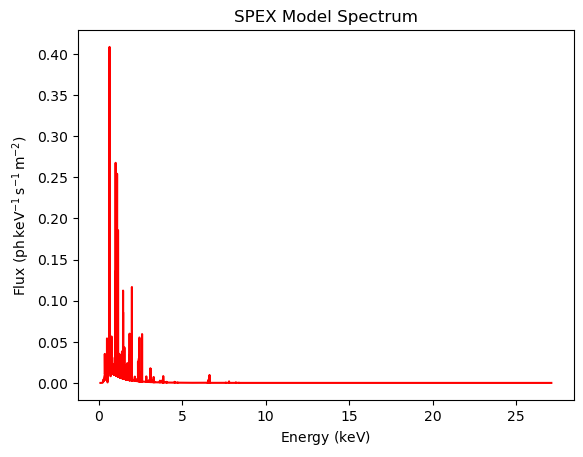

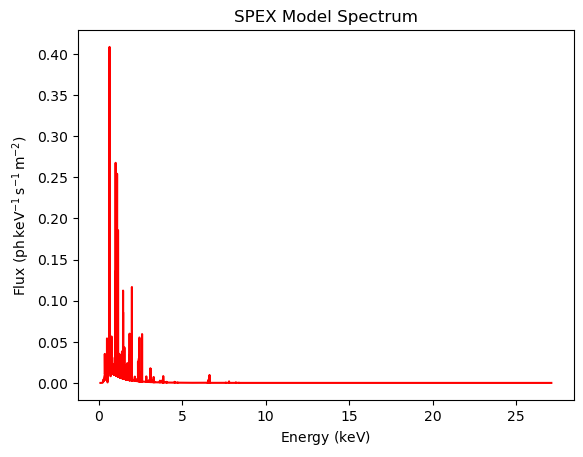

In [ ]:
# setup plot model
s.plot_model()
s.plot_model(xlog=False, ylog=False)
s.plot_model(wave=False)

In [ ]:
# qdp out
pl = s.plot_model()
data = pl.sector[0].tabmodel
x = data['X_ctr']
y = data['X_upp']
data['X_upp'] = y - x
np.savetxt("source.qdp", data, fmt=['%f','%f','%e'])


### common heasoft defs

---

In [ ]:
def runcmd(cmd):
    log.info('CMD: '+" ".join(cmd))
    log.info(cmd)
    check_call(cmd,env=os.environ)

def run_ftcopy(infile,ext,expr,outfile,copyall):
    copystr = "copyall=" + copyall
    if (expr.lower() == "none"):
        command = ["ftcopy","{0}[{1}]".format(infile,ext),outfile,copystr,"clobber=yes","history=yes"]
    else:
        command = ["ftcopy","{0}[{1}][{2}]".format(infile,ext,expr),outfile,copystr,"clobber=yes","history=yes"]
    runcmd(command)
    
def get_key(infile,extname,keyword):
    # Utility function for extracting FITS keywords
    hdulist = fits.open(infile)
    hdr = hdulist[extname].header
    hdulist.close()
    if (keyword in hdr):
        return(hdr[keyword])
    else:
        return("-1")


### interface to heasoft

---


In [ ]:
class taskpars:

    # The taskpars class consists of a task name, and a set of parameters of interest with default values in  
    # the form of a dictionary. With methods to initialize and update paramaters, and to run the tool, it
    # may be used to set up and run various ftools.
    def __init__(self,task,mydefaultpars):        
        self.task = task
        self.mydefaultpars = mydefaultpars
        self.pars = []
        self.values = []

    # Initialize the parameter values at their defaults.
    def initpars(self):
        self.pars = []
        self.values = []
        for key in self.mydefaultpars.keys():
            self.pars.append(key)
        for val in self.mydefaultpars.values():
            self.values.append(val)

    # Update a particular parameter with a particular value.
    def uppars(self,newpar,newval):
        idx = self.pars.index(newpar)
        self.values[idx] = newval

    # Construct the command string for a task with the current parameter settings, and run it.
    def runtask(self):
        command = []
        command.append(self.task)
        command_txt = self.task 
        for ii in range(len(self.mydefaultpars)):
            command.append(self.pars[ii] + '=' + self.values[ii])
            command_txt = command_txt + ' "' + self.pars[ii] + '=' + self.values[ii] + '"'
        command.append("clobber=yes")
        command_txt = command_txt + ' "clobber=yes"'
        runcmd(command)

### source definition file
#### RA, DEC, NH, spectrum(user), flux(0 for user), bandpass(0.-0. for user), specfile, specunits, specformat, source_specifications

In [ ]:
srctext = "60.,2.,0.0,user,0.,0.,0.-0.,source.qdp,2,2,extmod(beta,0.57,1.26,1.,0.,0.,5.7)"
file_path = "source.dat"
with open(file_path, "w") as file:
    file.write(srctext)      

### decompress support files to local
### define HEASIM_SUPPORT and run heasim

In [ ]:
## decompress
import subprocess
# Define the tar command
tar_cmd = "tar xzvf /FTP/xrism/FTP/prelaunch/simulation/sim3/heasimfiles_20201012.tar.gz"
# Run the tar command
try:
    subprocess.run(tar_cmd, shell=True)
except FileNotFoundError:
    print("tar command not found.")

## define HEASIM_SUPPORT
current_dir = os.getcwd()
data_dir = os.path.join(current_dir, 'heasimfiles/')
%env HEASIM_SUPPORT={data_dir}

## set default heasim
heasim = taskpars("heasim",{"mission":"hitomi","instrume":"sxs","rapoint":"-","decpoint":"-", \
                            "roll":"-","exposure":"-","insrcdeffile":"NONE","outfile":"NONE", \
                            "psffile":"NONE", "vigfile":"NONE","rmffile":"NONE","arffile":"NONE",\
                            "intbackfile":"NONE","flagsubex":"no","seed":"1"})
heasim.initpars()


In [ ]:
heasim.uppars("mission","hitomi")
heasim.uppars("instrume","sxs")
heasim.uppars("rapoint","60.")
heasim.uppars("decpoint","2.")
heasim.uppars("roll","0.0")
heasim.uppars("exposure","100000")
heasim.uppars("insrcdeffile","source.dat")
heasim.uppars("outfile","source.fits")
heasim.uppars("psffile","$HEASIM_SUPPORT/xrism/resolve/psf/eef_from_sxs_psfimage_20140618.fits")
heasim.uppars("vigfile","$HEASIM_SUPPORT/xrism/resolve/vignette/SXT_VIG_140618.txt")
heasim.uppars("rmffile","$HEASIM_SUPPORT/xrism/resolve/response/resolve_h7ev_2019a.rmf")
heasim.uppars("arffile","$HEASIM_SUPPORT/xrism/resolve/response/resolve_bet_spec_noGV_20190611.arf")
heasim.uppars("intbackfile","none")
heasim.uppars("flagsubex","no")
heasim.uppars("seed","1234567890")

heasim.runtask()

### exact spectrum using xselect

In [ ]:
## set XSELECT_MDB 
%env XSELECT_MDB={data_dir}/xrism/auxiliary/xselect.mdb.heasim

## set xselect commands
import subprocess
xselect_cmd = "bash -c 'xselect @xselect_script.xco'"

xselect_script = """


read events source.fits ./
yes
extract spectrum
save spectrum source.pi
yes
exit
no
"""

# Save the xselect script to a file
with open("xselect_script.xco", "w") as file:
    file.write(xselect_script)

# Run the xselect script
try:
    subprocess.run(xselect_cmd, shell=True)
    print("source.pi created")
except FileNotFoundError:
    print("xselect command not found.")
    


